# Mosquito Species Classification 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

In [2]:
class SincConvFast(Layer):


    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConvFast, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq
        self.stride = stride
        self.padding = padding
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Force filter size to be odd for later optimizations with symmetry
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        # Set trainable parameters
        self.low_hz = self.add_weight(
            name='low_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        self.band_hz = self.add_weight(
            name='band_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        
        # Initialize weights with frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(30)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2 - (self.min_low_hz + self.min_band_hz))
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters + 1)
        hz_points = self.mel_to_hz(mel_points)
        self.set_weights([hz_points[:-1], np.diff(hz_points)])
      
        # Determine half of t
        t_linspace = np.arange(-(self.kernel_size - 1) / 2, 0)
        t = tf.Variable(2 * np.pi * t_linspace / self.sample_freq)
        t = tf.cast(t, "float32")
        self.t = tf.reshape(t, (1, -1))

        # Determine half of the hamming window
        n = np.linspace(0, (self.kernel_size / 2) - 1, num=int((self.kernel_size / 2)))
        window = 0.54 - 0.46 * tf.cos(2 * np.pi * n / self.kernel_size)
        window = tf.cast(window, "float32")
        self.window = tf.Variable(window)

    def call(self, X):
        low = self.min_low_hz + tf.abs(self.low_hz)
        high = tf.clip_by_value(low + self.min_band_hz + tf.abs(self.band_hz), self.min_low_hz, self.sample_freq / 2)
        band = high - low

        low_times_t = tf.linalg.matmul(tf.reshape(low, (-1, 1)), self.t)
        high_times_t = tf.linalg.matmul(tf.reshape(high, (-1, 1)), self.t)

        band_pass_left = ((tf.sin(high_times_t) - tf.sin(low_times_t)) / (self.t / 2)) * self.window
        band_pass_center = tf.reshape(2 * band, (-1, 1))
        band_pass_right = tf.reverse(band_pass_left, [1])

        filters = tf.concat([band_pass_left,
                             band_pass_center,
                             band_pass_right], axis=1)
        filters = filters / (2 * band[:, None])

        # TF convolution assumes data is stored as NWC
        filters = tf.transpose(filters)
        filters = tf.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return tf.nn.conv1d(X, filters, self.stride, self.padding)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)


X = np.arange(63, dtype=np.single).reshape((1, 63, 1))
sinc_layer = SincConvFast(2, 9, 400)
y = sinc_layer(X)

print(y.numpy().transpose(0, 2, 1))

[[[-0.07339406 -0.09174238 -0.11009077 -0.12843938 -0.146788
   -0.1651365  -0.18348466 -0.20183326 -0.22018176 -0.23853038
   -0.256879   -0.27522764 -0.2935753  -0.31192377 -0.33027253
   -0.348621   -0.36696953 -0.38531825 -0.40366676 -0.42201528
   -0.44036403 -0.45871246 -0.47706097 -0.49540973 -0.5137573
   -0.53210604 -0.5504545  -0.568803   -0.5871527  -0.6054993
   -0.623848   -0.64219654 -0.66054505 -0.67889357 -0.697242
   -0.715591   -0.73394    -0.752288   -0.770636   -0.788985
   -0.8073345  -0.82568055 -0.8440305  -0.8623776  -0.8807265
   -0.8990751  -0.917425   -0.9357721  -0.95412105 -0.972469
   -0.99081707 -1.0091665  -1.0275155  -1.0458635  -1.0642116 ]
  [-0.18435074 -0.23043844 -0.27652615 -0.3226139  -0.36870134
   -0.41478932 -0.46087682 -0.50696474 -0.55305207 -0.59913963
   -0.64522773 -0.6913156  -0.737403   -0.7834905  -0.8295781
   -0.8756664  -0.92175376 -0.96784145 -1.013929   -1.0600163
   -1.1061046  -1.1521919  -1.1982797  -1.2443671  -1.2904555
   -1

## Load dataset 

In [3]:
sample_frequency = 8000 
frame_size = 0.1       
frame_stride = 0.01      
max_num_frames = 100

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128
classes = 4

print("Input length: {} ({}s)".format(frame_length, frame_size * max_num_frames))
print("Input shape: {}".format((batch_size, frame_length)))

Input length: 800 (10.0s)
Input shape: (128, 800)


#### Create Audio generator

In [4]:
from keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf
import glob

def get_frames_indices(filename):
    signal, fs = sf.read(filename)

    # Determine number of frames
    signal_length = len(signal)
    assert signal_length > frame_length
    num_frames = int(np.floor((signal_length - frame_length) / frame_step))

    # Limit the number of frames
    num_frames = min(num_frames, max_num_frames)

    return np.arange(0, num_frames * frame_step, frame_step)

def load_dataset(data_folder, max_species=8):
    X = []
    y = []

    files = glob.glob(data_folder)
     
    
    for species_id in range(min(max_species, len(files))):  
        
        species_files = glob.glob(files[species_id] + '/*') 
                
        for audio_id in range(len(species_files)):
            
            filename = species_files[audio_id]
            
            frames = get_frames_indices(filename)
                       
            for frame in frames:
                X.append([filename, frame])
                y.append(species_id)

    return X, y

class AudioGenerator(Sequence):

    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shape = (batch_size, frame_length, 1)

    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(int)

    def __getitem__(self, batch_id):
        X_batch = np.zeros((self.batch_size, frame_length, 1))
        y_batch = np.zeros(self.batch_size)

        for i in range(self.batch_size):
            id = batch_id * self.batch_size + i
            if id >= len(self.y):
                id = np.random.randint(0, len(self.y))

            path, frame = self.X[id]
            signal, fs = sf.read(path)

            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]

        return X_batch, y_batch

In [5]:
X_, y_ = load_dataset("D:/buzzNet/data/species_8/*", max_species=classes)

In [6]:
print(y_)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.20)

In [8]:
print("Size of X_train is:",np.shape(X_train))
print("Size of y_train is:",np.shape(y_train))
print("Size of X_val is:",np.shape(X_val))
print("Size of y_val is:",np.shape(y_val))

Size of X_train is: (35360, 2)
Size of y_train is: (35360,)
Size of X_val is: (8840, 2)
Size of y_val is: (8840,)


In [9]:
train_gen = AudioGenerator(X_train, y_train, batch_size)
val_gen = AudioGenerator(X_val, y_val, batch_size)

In [10]:
print("Number of training batches:", len(train_gen))
print("Number of validation batches:", len(val_gen))

Number of training batches: 277
Number of validation batches: 70


In [11]:
print(np.shape(val_gen))

(128, 800, 1)


### Create model

In [12]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Flatten, LayerNormalization, Dropout, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, FalseNegatives, Accuracy

In [13]:
def create_buzznet(enable_sincconv=True):
    model = Sequential()

    
    if (enable_sincconv):
        model.add(SincConvFast(256, 64, sample_frequency, input_shape=(frame_length, 1)))
    else:
        model.add(Conv1D(filters=256, kernel_size=64, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=128, kernel_size=32)) 
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    
    model.add(LSTM(64, return_sequences=True))
    
    model.add(LSTM(32, return_sequences=True))
    
    
    model.add(Conv1D(filters=64, kernel_size=16)) 
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))
 
  
    model.add(Flatten())   
    model.add(LayerNormalization())   
       
    model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.3)))    
    model.add(BatchNormalization(momentum=0.05))   
    model.add(LeakyReLU(alpha=0.2))   
    model.add(Dropout(0.30))   

    model.add(Dense(128, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.3)))   
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(name='layer_features', alpha=0.2))
    model.add(Dropout(0.30))

    model.add(Dense(classes, activation='softmax'))    

    return model

buzznet_model = create_buzznet()

In [14]:
buzznet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinc_conv_fast_1 (SincConvF  (None, 736, 256)         544       
 ast)                                                            
                                                                 
 max_pooling1d (MaxPooling1D  (None, 245, 256)         0         
 )                                                               
                                                                 
 layer_normalization (LayerN  (None, 245, 256)         512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 245, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 214, 128)          1048704   
                                                        

### Train model

In [15]:
buzznet_model.compile(optimizer=RMSprop(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

**Calculate only Accuracy**

In [17]:
checkpoint_path = "./checkpoints/training-{epoch:04d}.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

history = buzznet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=100,
                            initial_epoch=0,
                            callbacks=[save_callback])

Epoch 1/100
277/277 [==============================] - ETA: 0s - loss: 3.9591 - accuracy: 0.3517
Epoch 1: val_loss improved from inf to 2.49885, saving model to ./checkpoints\training-0001.ckpt
277/277 [==============================] - 177s 635ms/step - loss: 3.9591 - accuracy: 0.3517 - val_loss: 2.4988 - val_accuracy: 0.2523
Epoch 2/100
277/277 [==============================] - ETA: 0s - loss: 1.4642 - accuracy: 0.3890
Epoch 2: val_loss did not improve from 2.49885
277/277 [==============================] - 133s 479ms/step - loss: 1.4642 - accuracy: 0.3890 - val_loss: 5.8186 - val_accuracy: 0.1824
Epoch 3/100
277/277 [==============================] - ETA: 0s - loss: 1.3391 - accuracy: 0.4237
Epoch 3: val_loss improved from 2.49885 to 2.37358, saving model to ./checkpoints\training-0003.ckpt
277/277 [==============================] - 135s 486ms/step - loss: 1.3391 - accuracy: 0.4237 - val_loss: 2.3736 - val_accuracy: 0.4661
Epoch 4/100
277/277 [==============================] - ETA:

## Evaluate Model

#### Loss and accuracy

In [27]:
val_loss, val_accuracy = buzznet_model.evaluate(val_gen)

print("Loss on validation set:", val_loss)
print("Accuracy on validation set:", val_accuracy)

70/70 [==============================] - 16s 234ms/step - loss: 0.3010 - accuracy: 0.9359
Loss on validation set: 0.3010406792163849
Accuracy on validation set: 0.9359375238418579


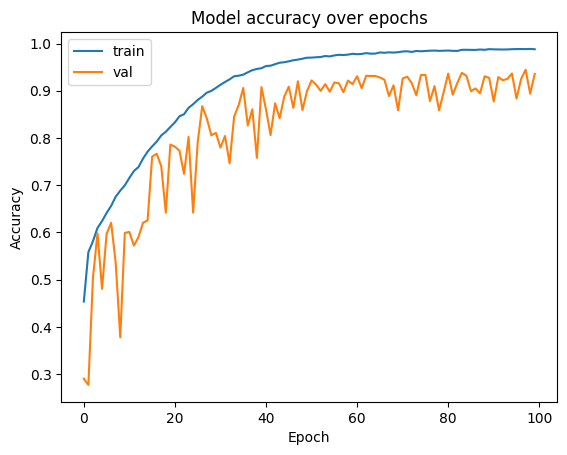

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Confusion matrix and metrics

In [29]:
nb_batches = len(val_gen)
X_val = np.empty((nb_batches, batch_size, frame_length, 1))
y_val = np.empty((nb_batches, batch_size))

for i in range(nb_batches):
    X_val[i], y_val[i] = val_gen.__getitem__(i)

X_val = X_val.reshape((nb_batches * batch_size, -1))
y_val = y_val.reshape(nb_batches * batch_size)

y_val_actual = np.argmax(buzznet_model.predict(X_val), axis=-1)

280/280 [==============================] - 5s 16ms/step


In [30]:
from sklearn.metrics import precision_recall_fscore_support

p, r, f1, _ = precision_recall_fscore_support(y_val,
                                              y_val_actual,
                                              average='macro',
                                              zero_division=0)

print("Precision:", p)
print("Recall:", r)
print("F1 score:", f1)

Precision: 0.9363490703023839
Recall: 0.9311754312089559
F1 score: 0.9335203482640155


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

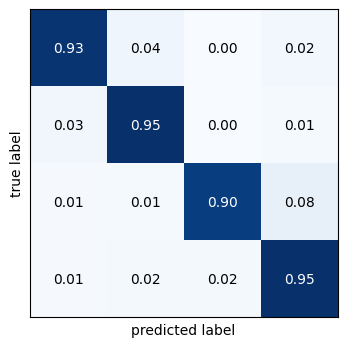

In [31]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_val, y_val_actual)

plot_confusion_matrix(cm,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(4, 4),
                      class_names=['an coustani', 'an squamosus', 'ma africanus', 'ma uniformis']
                      hide_ticks=True)
plt.savefig(r'D:\BuzzNet\data\species_8' + '_confusionMatrix.png'), bbox_inches='tight', dpi=500)